<a href="https://colab.research.google.com/github/HelenaNascimento/POS/blob/master/Atividade_ETL_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
pip install matplotlib

In [106]:
#pip install branca
#pip install folium
#pip install pandas
#pip install matplotlib

#branca = https://www.kaggle.com/code/stpeteishii/branca-colormap

# /content/sample_data/localizacao_cidades_CE.csv

"""
importar dados do arquivo para o programa
Dados sobre Cidades do Estado do Ceará
Código do IBGE;
Descrição da Cidade;
Posição Longitude e;
Posição Latitude

"""

# /content/sample_data/Dados_Vendas_JAN.csv

"""
importar dados sobre vendas dos clientes do mês de janeiro de 2024
Para selecionar a lista usei o select no banco SQL SERVER
  Select top 1000
    substring(cl.Fantasia, 1, 5) as Fantasia,
    Cod_CidIbge,
    sum(ve.Qtd_Total) as Qtd_Total_JAN,
    sum(ve.vlr_total) as vlr_total_JAN
  FROM tab_vendas vd
      inner join tab_cliente cl on vd.cod_clien = cod_clien
  where
    dat_venda >= '20240101'
    dat_venda <= '20240130'
  group by
    Cod_CidIbge

Como resultado da consulta vinheram os 1000 clientes que compraram no mês de Janeiro de 2024:
Fantasia, Código IBGE, Quantidade total de itens e valor total das compras dentro do perído

"""

"\nimportar dados sobre vendas dos clientes do mês de janeiro de 2024\nPara selecionar a lista usei o select no banco SQL SERVER\n  Select top 1000\n    substring(cl.Fantasia, 1, 5) as Fantasia,\n    Cod_CidIbge,\n    sum(ve.Qtd_Total) as Qtd_Total_JAN,\n    sum(ve.vlr_total) as vlr_total_JAN\n  FROM tab_vendas vd\n      inner join tab_cliente cl on vd.cod_clien = cod_clien\n  where \n    dat_venda >= '20240101'\n    dat_venda <= '20240130'\n  group by \n    Cod_CidIbge\n\nComo resultado da consulta vinheram os 1000 clientes que compraram no mês de Janeiro de 2024:\nFantasia, Código IBGE, Quantidade total de itens e valor total das compras dentro do perído\n\n"

In [107]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import matplotlib.pyplot as plt

In [108]:
# Função para carregar dados de cidades
def dados_cidade():
    imp_dados_cidade = pd.read_csv('/content/sample_data/localizacao_cidades_CE.csv', delimiter=';')
    print("Colunas do DataFrame de Cidades:", imp_dados_cidade.columns)
    # Renomear as colunas para corresponder ao que é esperado no merge
    imp_dados_cidade.rename(columns={'Longe': 'Longitude', 'Latit': 'Latitude'}, inplace=True)
    return imp_dados_cidade

In [109]:
# Função para carregar dados de vendas
def dados_vendas():
    imp_dados_vendas = pd.read_csv('/content/sample_data/Dados_Vendas_JAN.csv', delimiter=';')
    print("Colunas do DataFrame de Vendas:", imp_dados_vendas.columns)
    return imp_dados_vendas

In [110]:
# Função para combinar dados
def merge_data(imp_dados_vendas, imp_dados_cidade):
    #print("Verificando nomes das colunas antes do merge:")
    #print("Colunas de vendas:", imp_dados_vendas.columns)
    #print("Colunas de cidades:", imp_dados_cidade.columns)

    juncao_dos_dados = pd.merge(imp_dados_vendas, imp_dados_cidade, left_on='Cod_CidIbge', right_on='Cod_CidIbge', how='right')
    filtro_dados = juncao_dos_dados[['Fantasia', 'Cod_CidIbge', 'Cidade', 'Longitude', 'Latitude', 'Qtd_Total_JAN', 'vlr_total_JAN']]

    # Convertendo a coluna 'vlr_total_JAN' para numérico
    filtro_dados['vlr_total_JAN'] = pd.to_numeric(filtro_dados['vlr_total_JAN'], errors='coerce')
    return filtro_dados

In [111]:
# Função para criar mapa com marcadores coloridos
def create_map(dados):
    # Agrupar por cidade e calcular a soma dos valores de vendas
    grouped_data = dados.groupby(['Cod_CidIbge', 'Cidade', 'Longitude', 'Latitude']).agg({
        'vlr_total_JAN': 'sum'
    }).reset_index()

    # Filtrar dados com valores de vendas maiores que 0
    grouped_data = grouped_data[grouped_data['vlr_total_JAN'] > 0]

    # Criar um mapa base
    mapa = folium.Map(location=[-3.71722, -38.5433], zoom_start=7)  # Coordenadas aproximadas do Ceará

    # Criar um colormap de degradê
    colormap = cm.linear.BrBG_04.scale(grouped_data['vlr_total_JAN'].min(), grouped_data['vlr_total_JAN'].max())
    colormap.caption = 'Total de Vendas (R$)'
    colormap.add_to(mapa)

    # Adicionar marcadores ao mapa
    for _, row in grouped_data.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=10,
            popup=f"{row['Cidade']}<br>Total de Vendas: R${row['vlr_total_JAN']:.2f}",
            color=colormap(row['vlr_total_JAN']),
            fill=True,
            fill_color=colormap(row['vlr_total_JAN'])
        ).add_to(mapa)

    return mapa

In [112]:
imp_dados_cidade = dados_cidade()  # Carregar os dados da tabela cidade

Colunas do DataFrame de Cidades: Index(['Cod_CidIbge', 'Cidade', 'Longe', 'Latit'], dtype='object')


In [113]:
imp_dados_vendas = dados_vendas()  # Carregar os dados de Vendas

Colunas do DataFrame de Vendas: Index(['Cod_CidIbge', 'Fantasia', 'Qtd_Total_JAN', 'vlr_total_JAN'], dtype='object')


In [114]:
dados_combinados = merge_data(imp_dados_vendas, imp_dados_cidade) # Carregar os dados combinados

In [115]:
mapa_vendas = create_map(dados_combinados)  # Criar o mapa

In [116]:
mapa_vendas #exibir mapa

In [119]:
# Função para criar um gráfico de barras
def create_bar_chart(dados):
    # Agrupar por cidade e calcular a soma dos valores de vendas
    grouped_data = dados.groupby('Cidade').agg({
        'vlr_total_JAN': 'sum'
    }).reset_index()

    # Filtrar dados com valores de vendas maiores que 0
    grouped_data = grouped_data[grouped_data['vlr_total_JAN'] > 0]

    # Ordenar os dados por valor de vendas
    grouped_data = grouped_data.sort_values(by='vlr_total_JAN', ascending=False)

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 8))
    plt.bar(grouped_data['Cidade'], grouped_data['vlr_total_JAN'], color='skyblue')
    plt.xlabel('Cidade')
    plt.ylabel('Total de Vendas (R$)')
    plt.title('Total de Vendas por Cidade em Janeiro de 2024')
    plt.xticks(rotation=90)
    plt.show()


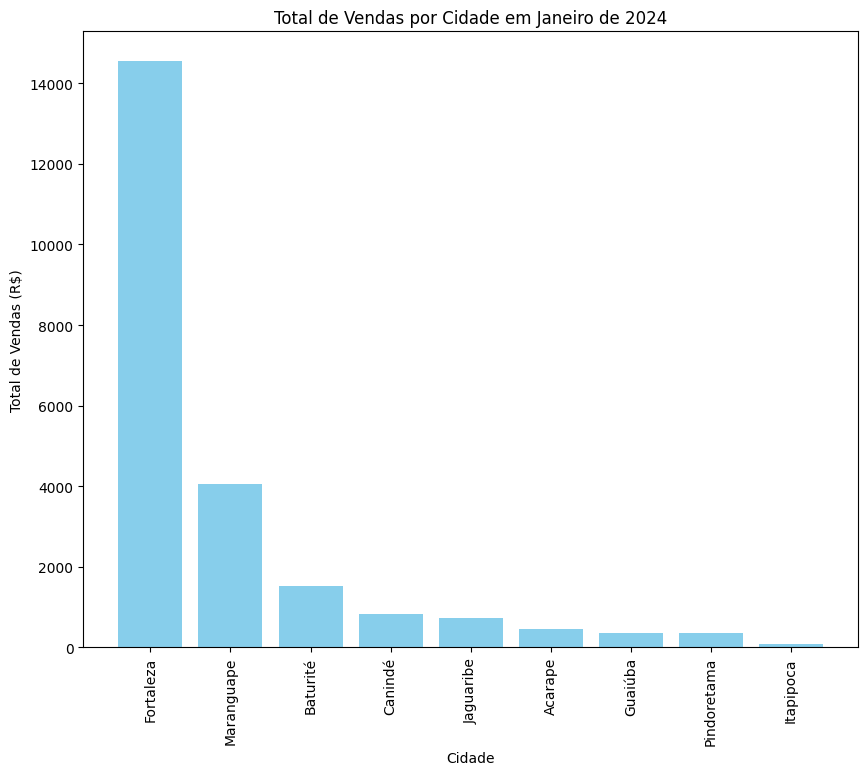

In [120]:
# Criar e exibir o gráfico de barras
create_bar_chart(dados_combinados)